## DSGE w. Feedback - Numerical Simulations

### Imports

In [2]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import model

## Simulation mechanics

In [57]:
def c_bound(z: float, k: float, p:dict):
    """Upper bound on the amount that can be consumed
    
    .. math:: c_t \leq z_t\cdotk_t\cdot\alpha^{-\frac{1}{\mu}}
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    return z * k * p['alpha'] ** (-1 / p['mu'])


def bisection(z:float, g:float, k:float, p:dict, precision:float=1e-7):
    """ Determine the level of consumption using the bisection method
    
    .. math:: \frac{2\gamma}{1-\alpha} c_t -  G_t z_t \left(c_t^{-\mu } z_t^{\mu }\right)^{-\frac{\mu +1}{\mu }} \left(\frac{c_t^{-\mu } z_t^{\mu }-\alpha  k_t^{-\mu }}{1-\alpha }\right)^{\frac{2}{\mu }+1} = 0
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    g : float
        Consumption rate (% of income consumed)
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
    precision : float, default: 1e-5
        Precision of the bisection solution
    
    Returns
    -------
    c : float
        level of consumption
    """
    
    # Pre-compute constants
    mu = p['mu']
    lhs_1 = 2 * p['gamma'] / (1 - p['alpha'])
    rhs_1 = g * z / ((1 - p['alpha']) ** (2 / mu + 1))
    rhs_2 = p['alpha'] * k ** (-1 * mu)
    
    # Minimisation target for the bisection
    def diff(c: float):
        r = z / c
        rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
        return c * lhs_1 - rhs
    
    max_val = c_bound(z, k, p)
    
    # Adapt by precision to avoid asymptotic bounds
    edge = precision * 1e-2
    x = [edge, max_val / 2, max_val-edge]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    # Conditions to stop: difference too small OR too close to the bound
    while all([min(abs_lst) >= precision, max_val - x[0] >= precision]):
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]     
        
        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [64]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    s = s_
    
    # Determine Consumption
    c = bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    #test = [income>0, w>0, n>0, k_>0, q_>0, b_>0]
    #assert all(test), print("w:{:.2f} n:{:.2f} b:{:.2f} q:{:.2f} k:{:.2f}".format(w,n,b_,q_,k_))
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Retain previous news formula out of interest
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * step_news)

    return z, c, n, b, w, k, q, g, s, news, income, xiz, xin

In [7]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p, err)
        if any([x[t,1]<err, x[t,2]<err, x[t,5]<err]): # c, n, k
            break
    x = x[:t+10,:]
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

<IPython.core.display.Javascript object>


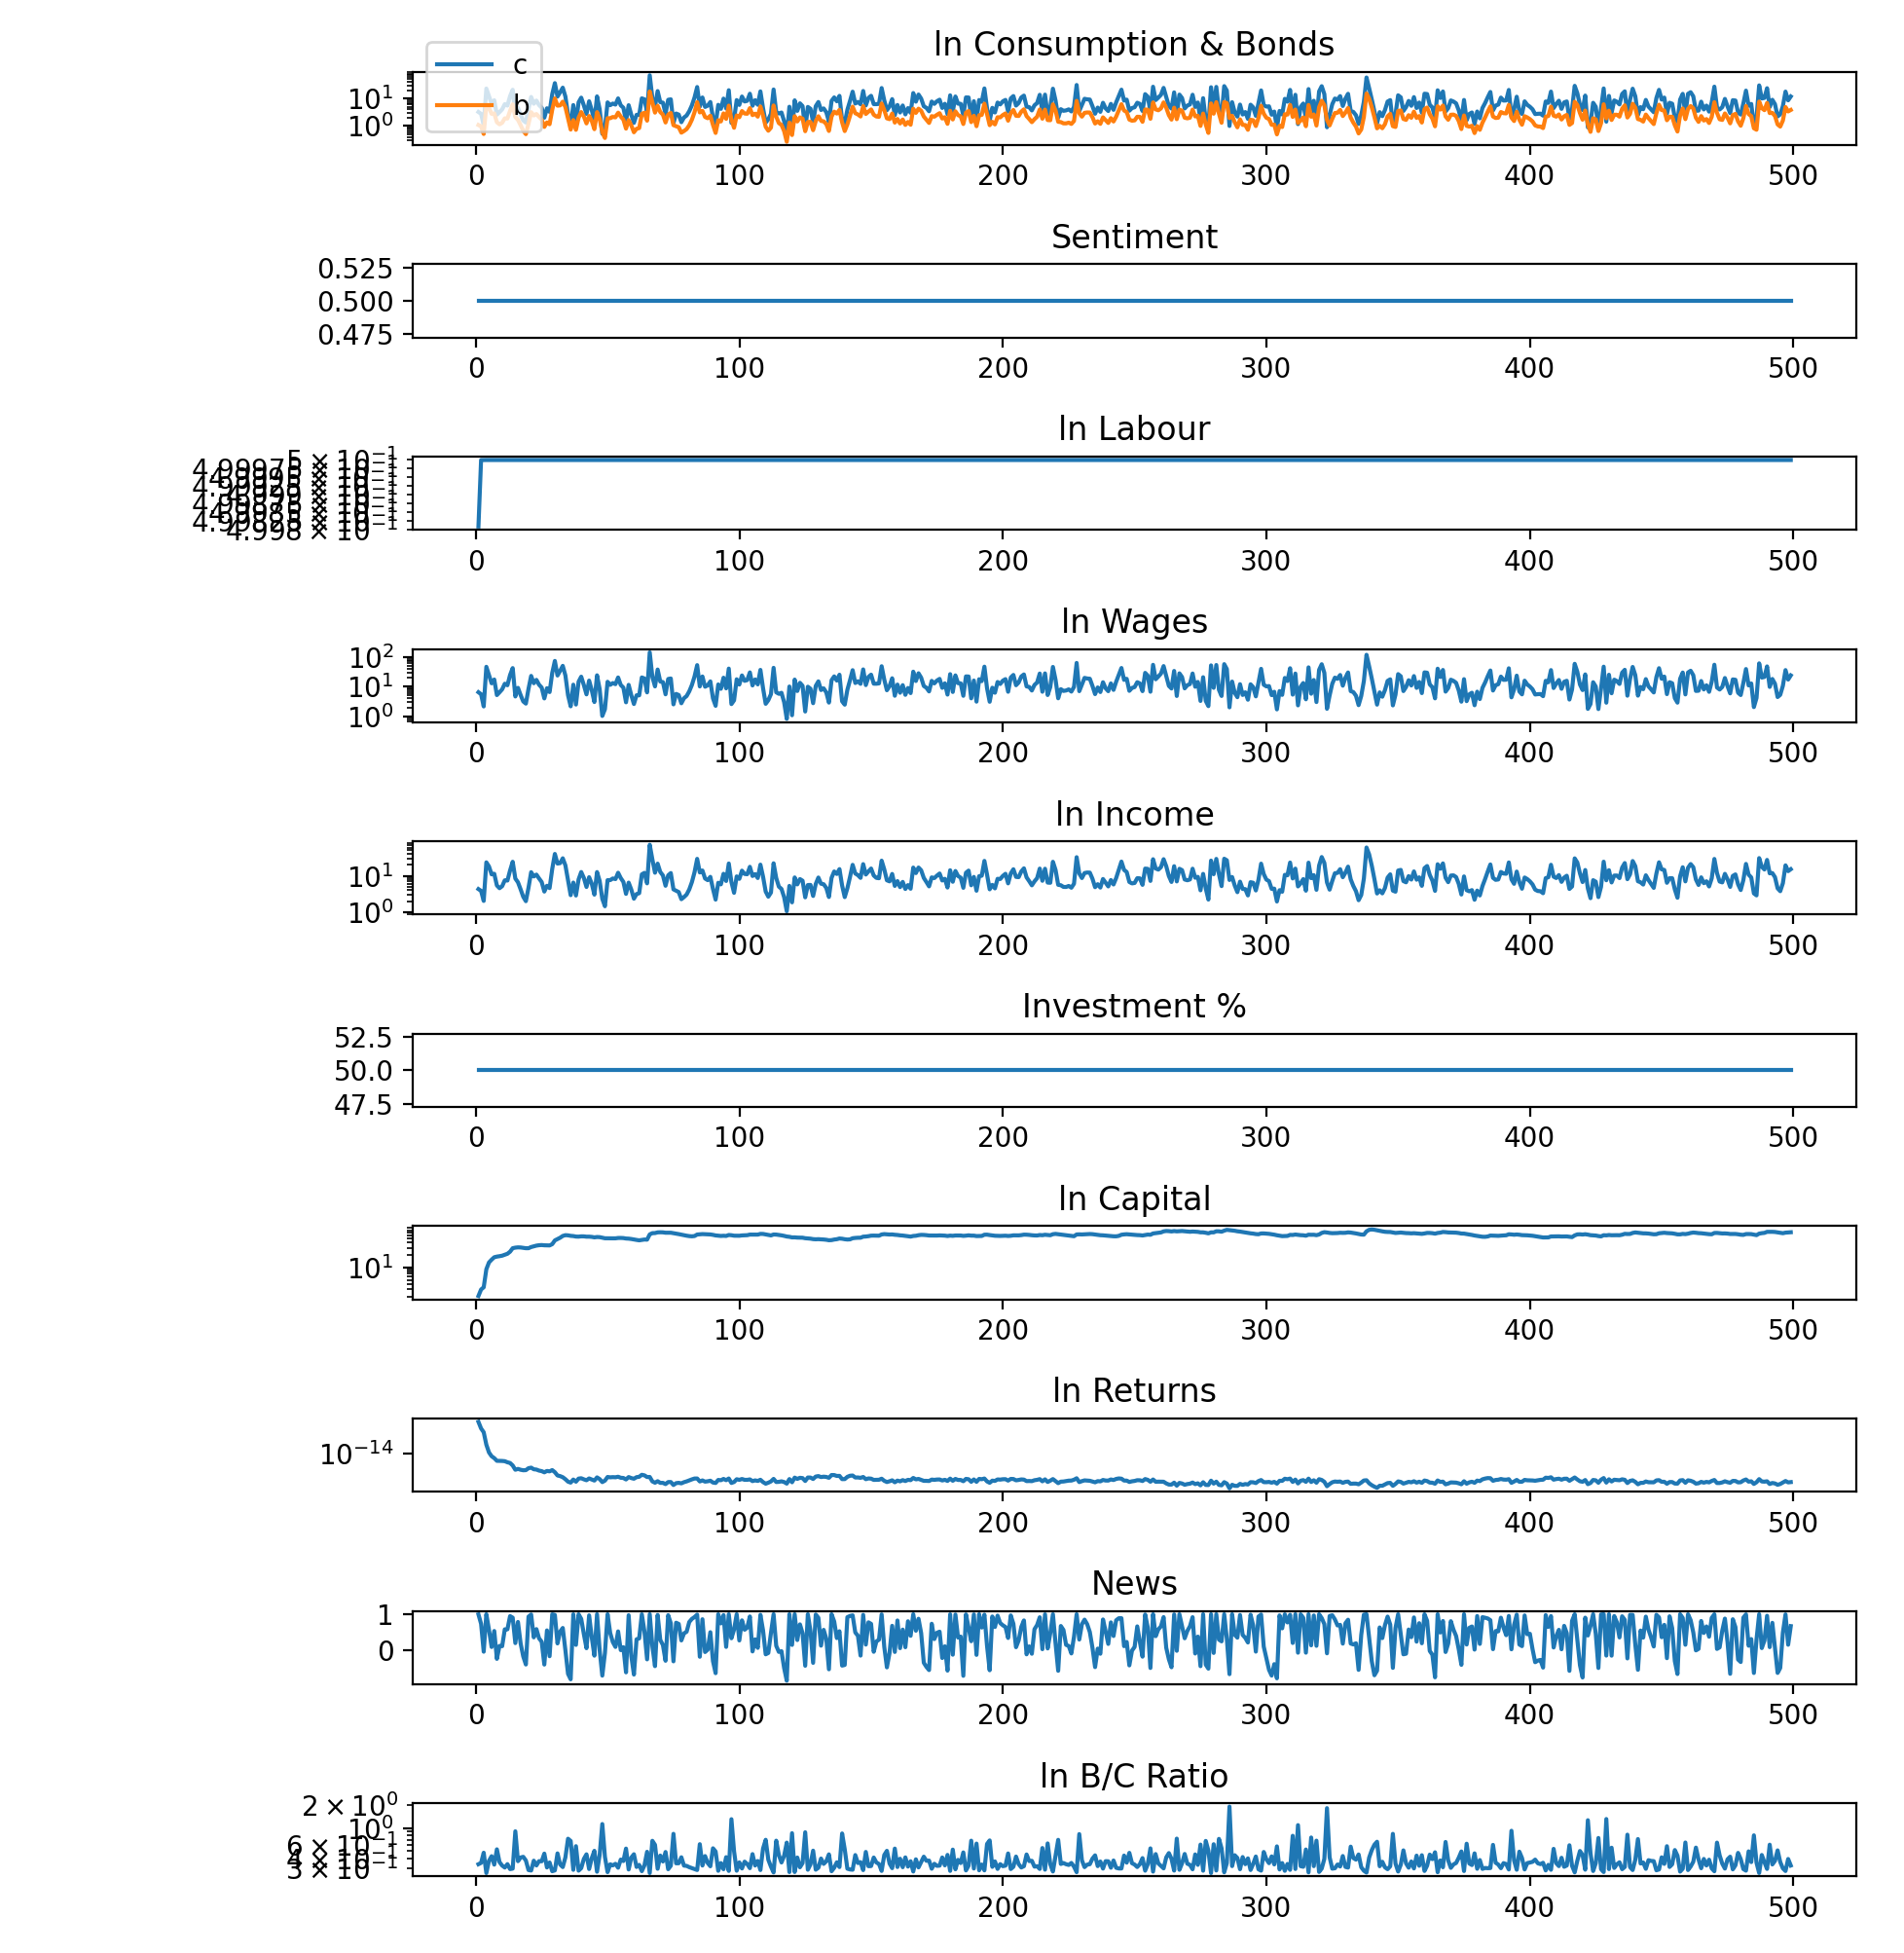

,z,c,n,b,w,k,q,g,s,news,income,xiz,xin,inv,bc
1,6.211279,3.240486,0.499808,1.092595,6.478485,2.041777,1.571365e-06,0.5,0.5,0.996071,4.327108,-0.476218,-0.025227,50.0,0.337170
2,5.316004,2.774703,0.500000,0.973761,5.549404,2.924226,3.317573e-08,0.5,0.5,0.734518,3.856481,-0.631863,0.185743,50.0,0.350943
3,2.076125,1.083640,0.500000,0.517059,2.167280,3.319197,3.504802e-09,0.5,0.5,-0.041768,2.047760,-1.572082,-0.093400,50.0,0.477151
4,44.040375,22.987011,0.500000,5.933485,45.974022,9.061167,2.345210e-12,0.5,0.5,1.000000,23.498951,1.482522,0.097762,50.0,0.258123
5,23.472342,12.251462,0.500000,4.576866,24.502925,13.230270,2.514423e-14,0.5,0.5,0.567671,18.126200,0.853238,0.211107,50.0,0.373577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.087609,2.655494,0.500000,0.957250,5.310987,68.689256,2.260957e-22,0.5,0.5,-0.493604,3.791088,-0.675777,-0.159341,50.0,0.360479
496,10.206571,5.327351,0.500000,1.584469,10.654703,67.510467,5.423018e-22,0.5,0.5,0.488969,6.275123,0.020447,-0.027214,50.0,0.297421
497,34.252678,17.878292,0.500000,4.910386,35.756585,69.671816,1.314668e-21,0.5,0.5,0.995059,19.447073,1.231180,0.204366,50.0,0.274656
498,16.487354,8.605626,0.500000,3.400517,17.211252,70.251792,5.809217e-22,0.5,0.5,0.151608,13.467394,0.500009,-0.224112,50.0,0.395150


In [79]:
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 10.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 2, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 9.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.5, s=.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 5e2
np.random.seed(40)
view = (1, int(T))


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','b']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = model.simulation_graph(graphs, size = (6, 10))
#axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)
df

---
## Steady-state Analysis

In [70]:
def steady_state_simulate(start: np.ndarray, p: dict, t_max: float = 2e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    #x = np.empty((int(t_max), len(start)))
    prior = start
    t = 1
    cond = 1
    while cond:
        new = step(t, prior, p, 1e-5)
        t +=1 
        cond = all([
            abs(new[5]-prior[5]) > err,
            any(np.isnan(new))==False,
            t <= t_max])
        prior = new
    
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    return pd.Series(new, index=cols)

def utility(c:float, n:float, gamma:float):
    return np.log(c) - gamma * n ** 2

In [75]:
from itertools import product
import seaborn as sns

# Parameters to vary
num = 25
T = 2e3
err = 1e-4
macro_vars = ['c', 'n', 'b', 'k', 'q', 'w']

# Parameter Variations
g_list = np.linspace(1e-3, 1-1e-3, num)
s_list = np.linspace(1e-3, 1-1e-3, num)

# Given parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}

results = {v:np.empty((num,num)) for v in macro_vars}

def sim_vars(g, s):
    start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, g=g, s=s, income=1, news=1, xiz=0, xin=0)
    start = np.array([v for _,v in start.items()])
    x = steady_state_simulate(start, params, t_max=T, err=err)
    x = x[[u, c, k, n]]
    return 

# Test 1
res = {k:pd.DataFrame(index=g_list, columns=s_list, dtype=float) for k in macro_vars}

for g, s in product(g_list,s_list):
    x = sim_vars(g,s)
    for k in res.keys():
        res[k].loc[g,s] = x.loc[k]

<IPython.core.display.Javascript object>


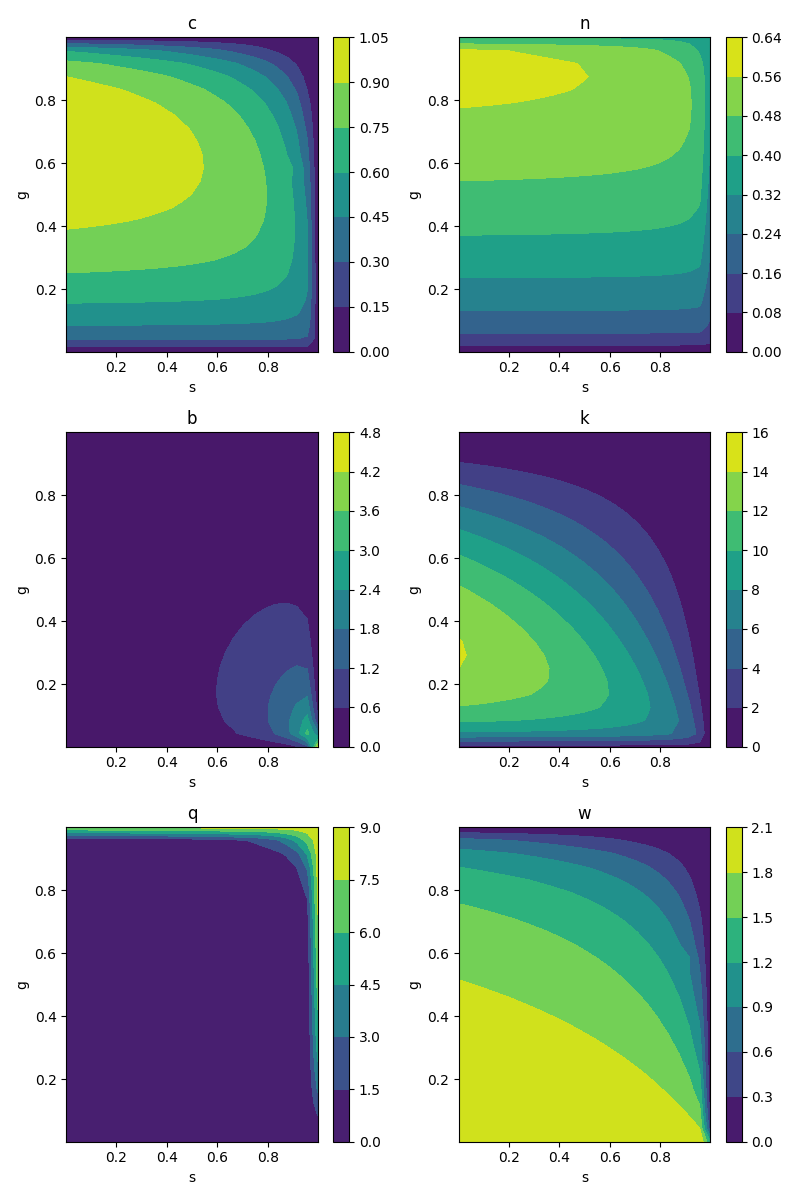

In [73]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
for i, k in enumerate(res.keys()):
    r, c = i//2, i%2
    ax[r, c].set_title(k)
    q = ax[r, c].contourf(s_list, g_list, res[k])
    ax[r, c].set_xlabel('s')
    ax[r, c].set_ylabel('g')
    cbar = plt.colorbar(q, ax=ax[r, c])
    
fig.tight_layout()
plt.savefig('fig_steady_state_heatmap2.pdf', bbox_inches='tight', format='pdf')